In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib_venn import venn2,venn3
from scipy.stats import median_abs_deviation
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import seaborn as sns

In [3]:
import pandas as pd

# Initialize an empty list to store the transcript information
transcript_data = []
i = 1
with open('/ceph/hpc/home/novljanj/data_storage/genomes/genome_m39/gencode.vM27.chr_patch_hapl_scaff.annotation.gtf', 'r') as gtf_file:
    for line in gtf_file:
        if line.startswith('#'):
            continue

        columns = line.strip().split('\t')
        attributes = columns[8]
        # Check if 'transcript_id' is in the attributes column
        if 'gene_id' in attributes:
            # Extract the transcript_id
            gene_name = [field for field in attributes.split(';') if 'gene_name' in field][0]
            gene_name = gene_name.split('"')[1]
            gene_id = [field for field in attributes.split(';') if 'gene_id' in field][0]
            gene_id = gene_id.split('"')[1]
            
            # Append the transcript_id to the list
            transcript_data.append(columns[:7] + [gene_name] + [gene_id])
                # Check if 'transcript_id' is in the attributes column

# Define the column names
column_names = ['seqname', 'source', 'feature', 'start', 'end', 'score', "strand", 'gene_name', 'gene_id']

# Convert the list to a DataFrame
annotation = pd.DataFrame(transcript_data, columns=column_names)
annotation['start'] = annotation['start'].astype(int) - 1
annotation = annotation[annotation['feature'] == 'gene']
annotation

,seqname,source,feature,start,end,score,strand,gene_name,gene_id
0,chr1,HAVANA,gene,3143475,3144545,.,+,4933401J01Rik,ENSMUSG00000102693.2
3,chr1,ENSEMBL,gene,3172238,3172348,.,+,Gm26206,ENSMUSG00000064842.3
6,chr1,HAVANA,gene,3276123,3741721,.,-,Xkr4,ENSMUSG00000051951.6
24,chr1,HAVANA,gene,3322979,3323459,.,+,Gm18956,ENSMUSG00000102851.2
27,chr1,HAVANA,gene,3435953,3438772,.,-,Gm37180,ENSMUSG00000103377.2
...,...,...,...,...,...,...,...,...,...
1869610,JH584299.1,ENSEMBL,gene,837363,840451,.,+,ENSMUSG00000095523,ENSMUSG00000095523.2
1869621,JH584299.1,ENSEMBL,gene,910288,913083,.,-,ENSMUSG00000095475,ENSMUSG00000095475.2
1869632,JH584299.1,ENSEMBL,gene,921941,924675,.,+,ENSMUSG00000094855,ENSMUSG00000094855.2
1869643,JH584303.1,ENSEMBL,gene,81606,82689,.,+,ENSMUSG00000095019,ENSMUSG00000095019.2


In [4]:
mESCs_IN_4sU60_rep1 = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/semi_oops_project/Data/nascent_riboseq_data/GSM5233895_IN_4sU60_rep1.csv')
mESCs_IN_4sU90_rep1 = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/semi_oops_project/Data/nascent_riboseq_data/GSM5233896_IN_4sU90_rep1.csv')
mESCs_IN_4sU120_rep1 = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/semi_oops_project/Data/nascent_riboseq_data/GSM5233897_IN_4sU120_rep1.csv')
mESCs_IN_4sU60_rep2 = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/semi_oops_project/Data/nascent_riboseq_data/GSM5233901_IN_4sU60_rep2.csv')
mESCs_IN_4sU90_rep2 = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/semi_oops_project/Data/nascent_riboseq_data/GSM5233902_IN_4sU90_rep2.csv')
mESCs_IN_4sU120_rep2 = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/semi_oops_project/Data/nascent_riboseq_data/GSM5233903_IN_4sU120_rep2.csv')

# List of your DataFrame variables
rnaseq_datasets = [
    mESCs_IN_4sU60_rep1, mESCs_IN_4sU90_rep1, mESCs_IN_4sU120_rep1,
    mESCs_IN_4sU60_rep2, mESCs_IN_4sU90_rep2, mESCs_IN_4sU120_rep2,
]

# Names of the datasets to use as column names in the final DataFrame
rnaseq_names = [
    'mESCs_IN_4sU60_rep1', 'mESCs_IN_4sU90_rep1', 'mESCs_IN_4sU120_rep1',
    'mESCs_IN_4sU60_rep2', 'mESCs_IN_4sU90_rep2', 'mESCs_IN_4sU120_rep2',
]

# Initialize an empty DataFrame to store sums
rnaseq = pd.DataFrame()

for df, name in zip(rnaseq_datasets, rnaseq_names):
    print(len(df))
    # Sort the DataFrame by 'gene' column to ensure matching gene names
    df_sorted = df.sort_values(by='gene').reset_index(drop=True)
    
    # Sum all columns except the 'gene' column
    sums = df_sorted.drop('gene', axis=1).sum(axis=1)
    
    # Create a temporary DataFrame to hold gene names and their corresponding sums
    temp_df = pd.DataFrame({
        'gene': df_sorted['gene'],
        name: sums
    })
    
    # If it's the first DataFrame, just copy it to sums_with_genes_df
    if rnaseq.empty:
        rnaseq = temp_df
    else:
        # Merge the new sums with the existing DataFrame on 'gene' to ensure correct alignment
        rnaseq = pd.merge(rnaseq, temp_df, on='gene', how='outer')

# Ensure the final DataFrame is sorted by gene names
rnaseq = rnaseq.sort_values(by='gene').reset_index(drop=True)

# drop na values
rnaseq = rnaseq.dropna()

# Calculating TPMs for each replicate (assuming sum normalization for simplicity)
def calculate_tpm(counts):
    total_counts = counts.sum()
    tpm = (counts / total_counts) * 1e6
    return tpm

rnaseq['TPM Replicate 1'] = calculate_tpm(rnaseq['mESCs_IN_4sU60_rep1'])
rnaseq['TPM Replicate 2'] = calculate_tpm(rnaseq['mESCs_IN_4sU60_rep1'])

rnaseq["0hrs_Replicate_Average_TPM"] = rnaseq[['TPM Replicate 1', 'TPM Replicate 1']].mean(axis=1)
nascent_rnaseq = rnaseq[['gene', '0hrs_Replicate_Average_TPM']]

nascent_rnaseq_gene_id = pd.merge(nascent_rnaseq, annotation, left_on='gene', right_on='gene_name', how='inner')
nascent_rnaseq_gene_id

14449
14585
14410
14976
14282
14923


,gene,0hrs_Replicate_Average_TPM,seqname,source,feature,start,end,score,strand,gene_name,gene_id
0,1810055G02Rik,19.461557,chr19,HAVANA,gene,3758292,3767881,.,+,1810055G02Rik,ENSMUSG00000035372.3
1,2310039H08Rik,0.973078,chr17,HAVANA,gene,47083560,47084322,.,+,2310039H08Rik,ENSMUSG00000062619.7
2,2700062C07Rik,12.974371,chr18,HAVANA,gene,24603906,24610855,.,+,2700062C07Rik,ENSMUSG00000024273.9
3,3110082I17Rik,21.407713,chr5,HAVANA,gene,139345493,139446282,.,-,3110082I17Rik,ENSMUSG00000053553.12
4,8030462N17Rik,58.060312,chr18,HAVANA,gene,77719192,77802186,.,-,8030462N17Rik,ENSMUSG00000047466.11
...,...,...,...,...,...,...,...,...,...,...,...
12073,mt-Nd3,570.872342,chrM,ENSEMBL,gene,9458,9806,.,+,mt-Nd3,ENSMUSG00000064360.1
12074,mt-Nd4,842.361063,chrM,ENSEMBL,gene,10166,11544,.,+,mt-Nd4,ENSMUSG00000064363.1
12075,mt-Nd4l,139.150133,chrM,ENSEMBL,gene,9876,10173,.,+,mt-Nd4l,ENSMUSG00000065947.1
12076,mt-Nd5,855.984153,chrM,ENSEMBL,gene,11741,13565,.,+,mt-Nd5,ENSMUSG00000064367.1


In [5]:
jothi_rnasaq = pd.read_excel('/ceph/hpc/home/novljanj/data_storage/projects/semi_oops_project/Data/jothi_proteome_and_rnaseq/jothi RNAseq development.xlsx', sheet_name='Raw Transcriptome Data')
jothi_rnasaq_naive = jothi_rnasaq[['Unnamed: 0',	'symbol',	'0hrs Replicate 1',	'0hrs Replicate 2']]

# Calculating TPMs for each replicate (assuming sum normalization for simplicity)
def calculate_tpm(counts):
    total_counts = counts.sum()
    tpm = (counts / total_counts) * 1e6
    return tpm

jothi_rnasaq_naive['TPM Replicate 1'] = calculate_tpm(jothi_rnasaq_naive['0hrs Replicate 1'])
jothi_rnasaq_naive['TPM Replicate 2'] = calculate_tpm(jothi_rnasaq_naive['0hrs Replicate 2'])


jothi_rnasaq_naive["0hrs_Replicate_Average_TPM"] = jothi_rnasaq_naive[['TPM Replicate 1', 'TPM Replicate 1']].mean(axis=1)
jothi_rnasaq_naive = jothi_rnasaq_naive[['Unnamed: 0', 'symbol', '0hrs_Replicate_Average_TPM']]
jothi_rnasaq_naive

/tmp/ipykernel_3118378/3919639201.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jothi_rnasaq_naive['TPM Replicate 1'] = calculate_tpm(jothi_rnasaq_naive['0hrs Replicate 1'])
/tmp/ipykernel_3118378/3919639201.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jothi_rnasaq_naive['TPM Replicate 2'] = calculate_tpm(jothi_rnasaq_naive['0hrs Replicate 2'])
/tmp/ipykernel_3118378/3919639201.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

,Unnamed: 0,symbol,0hrs_Replicate_Average_TPM
0,ENSMUSG00000085214,0610005C13Rik,0.379756
1,ENSMUSG00000021252,0610007P14Rik,38.334272
2,ENSMUSG00000007777,0610009B22Rik,14.430733
3,ENSMUSG00000086714,0610009E02Rik,0.232073
4,ENSMUSG00000043644,0610009L18Rik,0.506342
...,...,...,...
20931,ENSMUSG00000034645,Zyg11a,55.697567
20932,ENSMUSG00000034636,Zyg11b,141.121600
20933,ENSMUSG00000029860,Zyx,3.059147
20934,ENSMUSG00000055670,Zzef1,57.174396


In [6]:
expression_data = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Data/salmon_count_tables/salmon.merged.gene_counts.tsv', sep="\t")

# Define the sets of triplets
triplets = [
    ('control_diff', 'control_diff_1', 'control_diff_2', 'control_diff_3'),
    ('control_epiSC', 'control_epiSC_1', 'control_epiSC_2', 'control_epiSC_3'),
    ('control_naive', 'control_naive_1', 'control_naive_2', 'control_naive_3'),
    ('oops_diff', 'oops_diff_1', 'oops_diff_2', 'placeholder'),
    ('oops_epiSC', 'oops_epiSC_1', 'oops_epiSC_2', 'oops_epiSC_3'),
    ('oops_naive', 'oops_naive_1', 'oops_naive_2', 'oops_naive_3'),
    ('semi_diff', 'semi_diff_1', 'semi_diff_2', 'semi_diff_3'),
    ('semi_epiSC', 'semi_epiSC_1', 'semi_epiSC_2', 'semi_epiSC_3'),
    ('semi_naive', 'semi_naive_1', 'semi_naive_2', 'semi_naive_3'),
]

def calculate_tpm(counts):
        total_counts = counts.sum()
        tpm = (counts / total_counts) * 1e6
        return tpm
    
for column in ['control_diff_1', 'control_diff_2', 'control_diff_3', 'control_epiSC_1', 'control_epiSC_2', 'control_epiSC_3','control_naive_1',
    'control_naive_2', 'control_naive_3','oops_diff_1', 'oops_diff_2', 'oops_epiSC_1', 'oops_epiSC_2', 'oops_epiSC_3','oops_naive_1', 'oops_naive_2', 'oops_naive_3','semi_diff_1', 'semi_diff_2', 'semi_diff_3',
    'semi_epiSC_1', 'semi_epiSC_2', 'semi_epiSC_3','semi_naive_1', 'semi_naive_2', 'semi_naive_3']:

    expression_data[column] = calculate_tpm(expression_data[column])
    

expression_data_mean = expression_data[['gene_id',	'gene_name']].copy()

# Calculate the mean for each triplet
for triplet in triplets:
    name, col1, col2, col3 = triplet
    if col3 == 'placeholder':
        expression_data_mean[f'{name}_mean'] = expression_data[[col1, col2]].mean(axis=1)
    else:
        expression_data_mean[f'{name}_mean'] = expression_data[[col1, col2, col3]].mean(axis=1)

expression_data_mean

,gene_id,gene_name,control_diff_mean,control_epiSC_mean,control_naive_mean,oops_diff_mean,oops_epiSC_mean,oops_naive_mean,semi_diff_mean,semi_epiSC_mean,semi_naive_mean
0,ENSMUSG00000000001.5,Gnai3,184.709271,162.111676,91.547873,245.034191,227.260984,173.533202,194.989770,180.060757,103.504184
1,ENSMUSG00000000003.16,Pbsn,0.000000,0.027547,0.000000,0.031510,0.000000,0.000000,0.000000,0.000000,0.000000
2,ENSMUSG00000000028.16,Cdc45,76.379686,77.658066,94.322656,42.784360,41.910642,51.567936,50.825778,55.274037,81.029394
3,ENSMUSG00000000031.17,H19,0.155731,0.094867,0.100248,0.106507,0.108217,0.081605,0.164562,0.178969,0.137337
4,ENSMUSG00000000037.18,Scml2,19.535287,9.587724,2.197412,21.262979,9.965226,3.132768,23.719065,10.503585,1.847272
...,...,...,...,...,...,...,...,...,...,...,...
55354,ENSMUSG00002076988.1,5S_rRNA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
55355,ENSMUSG00002076989.1,U1,0.034944,0.032064,0.201564,0.043747,0.029552,0.047747,0.153383,0.071212,0.119546
55356,ENSMUSG00002076990.1,ENSMUSG00002076990,0.128150,0.223221,0.065500,0.224989,0.131107,0.000000,0.301956,0.173402,0.000000
55357,ENSMUSG00002076991.1,7SK,0.000000,0.000000,0.000000,0.000000,0.000000,0.050375,0.000000,0.000000,0.000000


In [7]:
semi_naive_deseq = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Data/deseq2_results_tables/semi_naive_vs_control_naive_deseq.tsv', sep="\t")
oops_naive_deseq = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Data/deseq2_results_tables/oops_naive_vs_control_naive_deseq.tsv', sep="\t")
semi_epi_deseq = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Data/deseq2_results_tables/semi_epi_vs_control_epi_deseq.tsv', sep="\t")
oops_epi_deseq = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Data/deseq2_results_tables/oops_epi_vs_control_epi_deseq.tsv', sep="\t")
semi_diff_deseq = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Data/deseq2_results_tables/semi_diff_vs_control_diff_deseq.tsv', sep="\t")
oops_diff_deseq = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Data/deseq2_results_tables/oops_diff_vs_control_diff_deseq.tsv', sep="\t")

In [8]:
def subset_genes(semi, oops, type):
    if type == "smoops":
        semi_subset = semi[(semi['padj'] < 0.01) & (semi['log2FoldChange'] > 1)]
        oops_subset = oops[(oops['padj'] < 0.01) & (oops['log2FoldChange'] > 1)]
    else:
        semi_subset = semi[(semi['padj'] > 0.05) & ((semi['log2FoldChange'] > -0.5) & (semi['log2FoldChange'] < 0.5))]
        oops_subset = oops[(oops['padj'] > 0.05) & ((oops['log2FoldChange'] > -0.5) & (oops['log2FoldChange'] < 0.5))]
        
    semi_genes_subset = set(semi_subset['gene_id'])
    oops_genes_subset = set(oops_subset['gene_id'])
        
    subset_genes = semi_genes_subset.intersection(oops_genes_subset)
    
    return subset_genes

smoops_naive_overlap = subset_genes(semi_naive_deseq, oops_naive_deseq, "smoops")
control_naive_overlap = subset_genes(semi_naive_deseq, oops_naive_deseq, "control")


449
1328
1390
smoops_naive 449 smoops_epi 1328 smoops_diff 1390


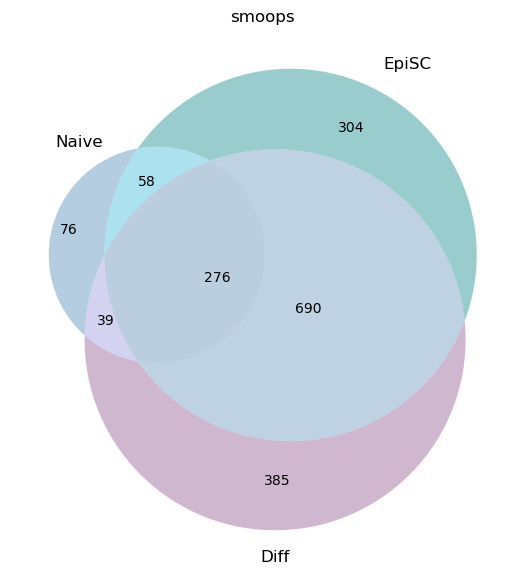

4038
4011
4427
control_naive 4038 control_epi 4011 control_diff 4427


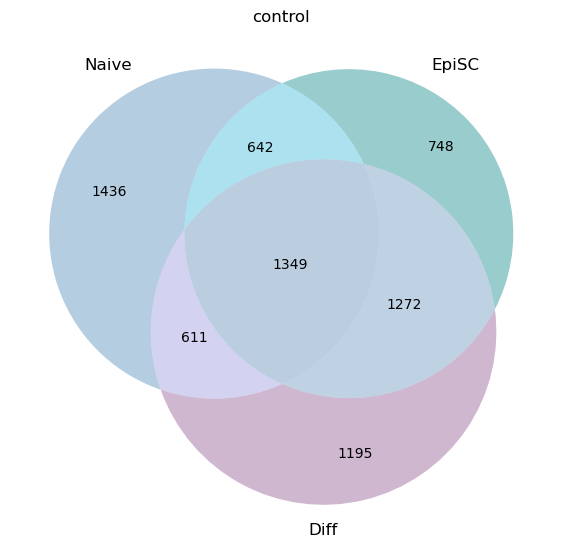

control_common 1349


In [9]:
def subset_genes(semi, oops, type):
    
    if type == "smoops":
        change_smoops = 2
        semi_subset = semi[(semi['padj'] < 0.01) & (semi['log2FoldChange'] > math.log2(change_smoops))]
        oops_subset = oops[(oops['padj'] < 0.01) & (oops['log2FoldChange'] > math.log2(change_smoops))]
    else:
        change_control = 1.4
        semi_subset = semi[(semi['padj'] > 0.01) & ((semi['log2FoldChange'] > -math.log2(change_control)) & (semi['log2FoldChange'] < math.log2(change_control)))]
        oops_subset = oops[(oops['padj'] > 0.01) & ((oops['log2FoldChange'] > -math.log2(change_control)) & (oops['log2FoldChange'] < math.log2(change_control)))]
        
    semi_genes_subset = set(semi_subset['gene_id'])
    oops_genes_subset = set(oops_subset['gene_id'])
    subset_genes = semi_genes_subset.intersection(oops_genes_subset)
    print(len(subset_genes))
    return subset_genes

def plot_venn_for_all_states(naive, epi, diff, title):
    plt.figure(figsize=(7,7))
    venn3([naive, epi, diff], ('Naive', 'EpiSC', 'Diff'), set_colors=("#4682B4", "#008080", "#894c89"))
    plt.title(title)
    plt.show()
    
    
# SMOOPS
smoops_naive = subset_genes(semi_naive_deseq, oops_naive_deseq, "smoops")
smoops_epi = subset_genes(semi_epi_deseq, oops_epi_deseq, "smoops")
smoops_diff = subset_genes(semi_diff_deseq, oops_diff_deseq, "smoops")
print("smoops_naive", len(smoops_naive), "smoops_epi", len(smoops_epi), "smoops_diff", len(smoops_diff))
plot_venn_for_all_states(smoops_naive, smoops_epi, smoops_diff, "smoops")

# CONTROL
control_naive = subset_genes(semi_naive_deseq, oops_naive_deseq, "control")
control_epi = subset_genes(semi_epi_deseq, oops_epi_deseq, "control")
control_diff = subset_genes(semi_diff_deseq, oops_diff_deseq, "control")
print("control_naive", len(control_naive), "control_epi", len(control_epi), "control_diff", len(control_diff))
plot_venn_for_all_states(control_naive, control_epi, control_diff, "control")

control_common = control_naive.intersection(control_epi).intersection(control_diff)
print("control_common", len(control_common))

1349


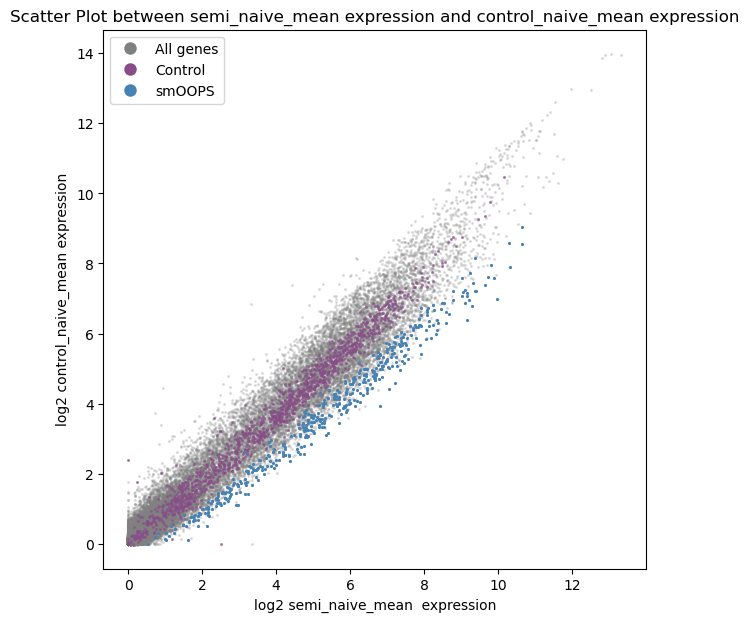

In [10]:
from matplotlib.lines import Line2D

def plot_scatterplot(expression_data_mean, column_name1, column_name2, set1, set2):

    expression_data_mean[f"log2 {column_name1}"] = np.log2(expression_data_mean[column_name1] + 1)
    expression_data_mean[f"log2 {column_name2}"] = np.log2(expression_data_mean[column_name2] + 1)
    
    # Colors based on gene set membership
    colors = []
    for gene in expression_data_mean['gene_id']:
        if gene in set1:
            colors.append('#4682B4')  # Pale lavender color
        elif gene in set2:
            colors.append('#894c89')  # Steel blue color
        else:
            colors.append('grey')  # Default color for genes not in set1 or set2

    # Creating a scatterplot
    plt.figure(figsize=(7, 7))
    
    plt.scatter(expression_data_mean[~((expression_data_mean["gene_id"].isin(set1)) & (expression_data_mean["gene_id"].isin(set2)))][f"log2 {column_name1}"], expression_data_mean[~((expression_data_mean["gene_id"].isin(set1)) & (expression_data_mean["gene_id"].isin(set2)))][f"log2 {column_name2}"], s=1.5, alpha=0.2, color='grey')
    plt.scatter(expression_data_mean[expression_data_mean["gene_id"].isin(set2)][f"log2 {column_name1}"], expression_data_mean[expression_data_mean["gene_id"].isin(set2)][f"log2 {column_name2}"], s=1.5, alpha=0.5, color ='#894c89')    
    plt.scatter(expression_data_mean[expression_data_mean["gene_id"].isin(set1)][f"log2 {column_name1}"], expression_data_mean[expression_data_mean["gene_id"].isin(set1)][f"log2 {column_name2}"], s=1.5, alpha=1, color='#4682B4')    
    
    plt.xlabel(f'log2 {column_name1}  expression')
    plt.ylabel(f'log2 {column_name2} expression')
    plt.title(f'Scatter Plot between {column_name1} expression and {column_name2} expression')
    # Create custom legends
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='All genes', markerfacecolor='grey', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Control', markerfacecolor='#894c89', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='smOOPS', markerfacecolor='#4682B4', markersize=10)
    ]

    # Create a legend with custom handles
    plt.legend(handles=legend_elements, loc='best')
    
    plt.show()
    
print(len(control_common))
plot_scatterplot(expression_data_mean, 'semi_naive_mean', 'control_naive_mean', smoops_naive, control_common)

1349


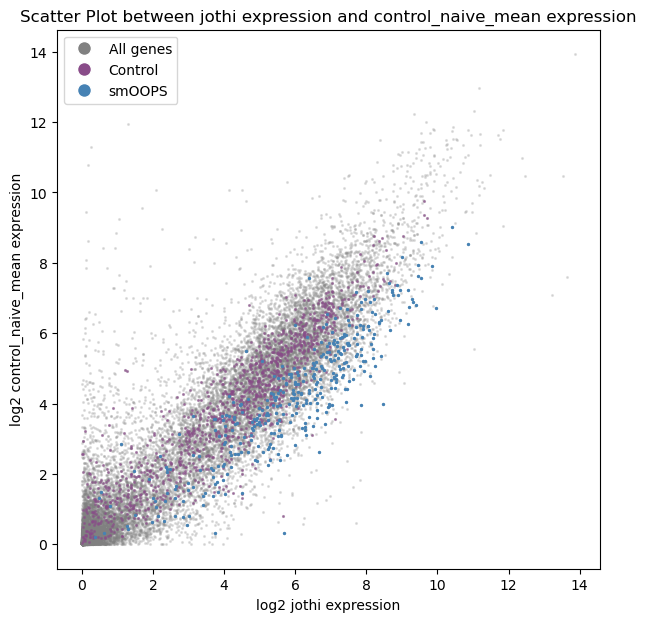

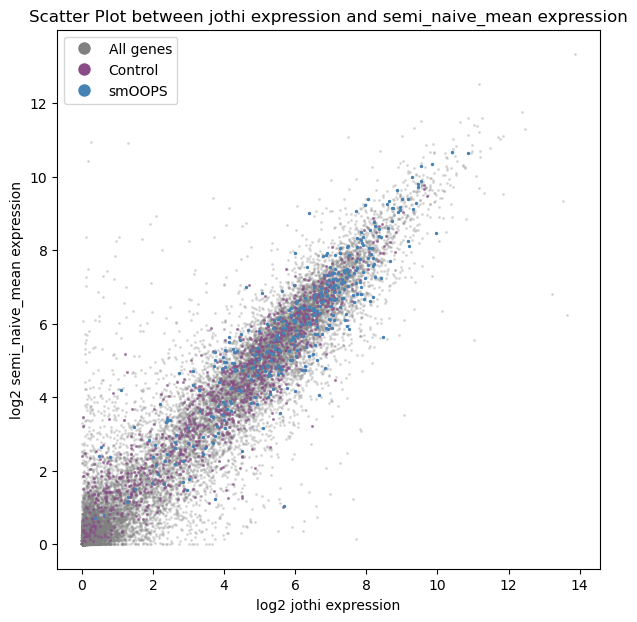

In [11]:
from matplotlib.lines import Line2D

def plot_scatterplot(jothi, expression_data_mean, column_name, set1, set2):
    expression_data_mean_no_version = expression_data_mean.copy()
    expression_data_mean_no_version["gene_id"] =  expression_data_mean["gene_id"].str.split(".").str[0]
    set1 = set([gene.split('.')[0] for gene in set1])
    set2 = set([gene.split('.')[0] for gene in set2])
    # Merging datasets on 'gene_id' and 'Unnamed: 0'
    merged_data = pd.merge(jothi, expression_data_mean_no_version, left_on=['Unnamed: 0'], right_on=["gene_id"], how='inner')

    # Assume 'column_from_dataset1' and 'column_from_dataset2' are the names of the columns you want to plot
    # Replace them with the actual column names you're interested in
    merged_data['log2_0hrs_Replicate_Average_TPM'] = np.log2(merged_data['0hrs_Replicate_Average_TPM'] + 1)
    merged_data[f"log2 {column_name}"] = np.log2(merged_data[column_name] + 1)
    
    # Colors based on gene set membership
    colors = []
    for gene in merged_data['gene_id']:
        if gene in set1:
            colors.append('#4682B4')  # Pale lavender color
        elif gene in set2:
            colors.append('#894c89')  # Steel blue color
        else:
            colors.append('grey')  # Default color for genes not in set1 or set2

    # Creating a scatterplot
    plt.figure(figsize=(7, 7))
    
    plt.scatter(merged_data[~((merged_data["gene_id"].isin(set1)) & (merged_data["gene_id"].isin(set2)))]['log2_0hrs_Replicate_Average_TPM'], merged_data[~((merged_data["gene_id"].isin(set1)) & (merged_data["gene_id"].isin(set2)))][f"log2 {column_name}"], s=1.5, alpha=0.2, color='grey')
    plt.scatter(merged_data[merged_data["gene_id"].isin(set2)]['log2_0hrs_Replicate_Average_TPM'], merged_data[merged_data["gene_id"].isin(set2)][f"log2 {column_name}"], s=1.5, alpha=0.5, color ='#894c89')    
    plt.scatter(merged_data[merged_data["gene_id"].isin(set1)]['log2_0hrs_Replicate_Average_TPM'], merged_data[merged_data["gene_id"].isin(set1)][f"log2 {column_name}"], s=2, alpha=1, color='#4682B4')    
    
    plt.xlabel('log2 jothi expression')
    plt.ylabel(f'log2 {column_name} expression')
    plt.title(f'Scatter Plot between jothi expression and {column_name} expression')
    # Create custom legends
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='All genes', markerfacecolor='grey', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Control', markerfacecolor='#894c89', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='smOOPS', markerfacecolor='#4682B4', markersize=10)
    ]

    # Create a legend with custom handles
    plt.legend(handles=legend_elements, loc='best')
    
    plt.show()
    
print(len(control_common))
plot_scatterplot(jothi_rnasaq_naive, expression_data_mean, 'control_naive_mean', smoops_naive, control_common)
plot_scatterplot(jothi_rnasaq_naive, expression_data_mean, 'semi_naive_mean', smoops_naive, control_common)


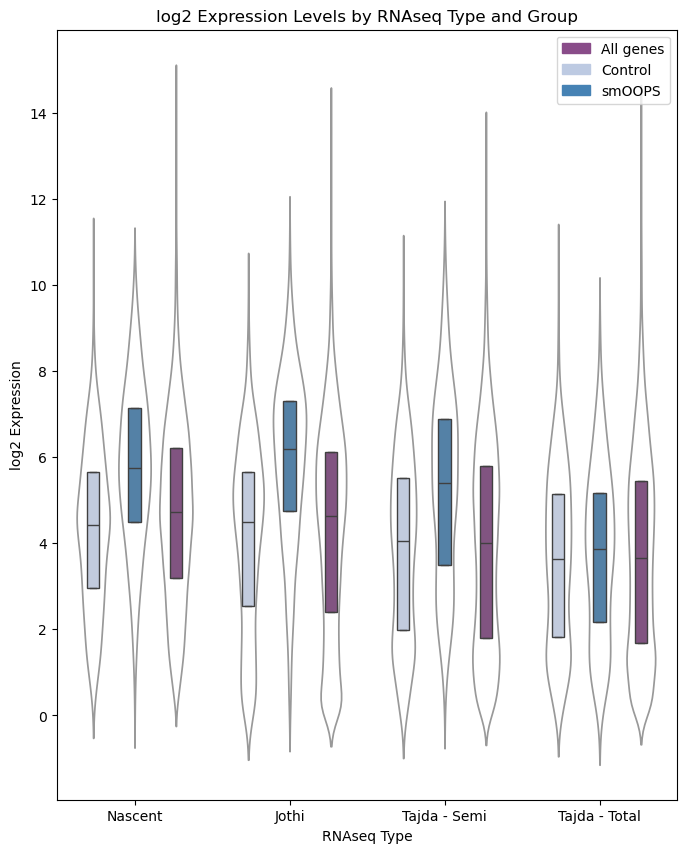

/tmp/ipykernel_3118378/702204396.py:97: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='RNAseq_Type', y='log2 Expression', hue='Group', data=combined_data, palette=hex_palette, markers=['o', 's', '^'], dodge=0.2, join=False, capsize=0.05, errorbar="sd")


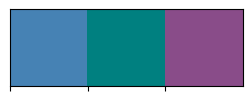

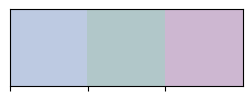

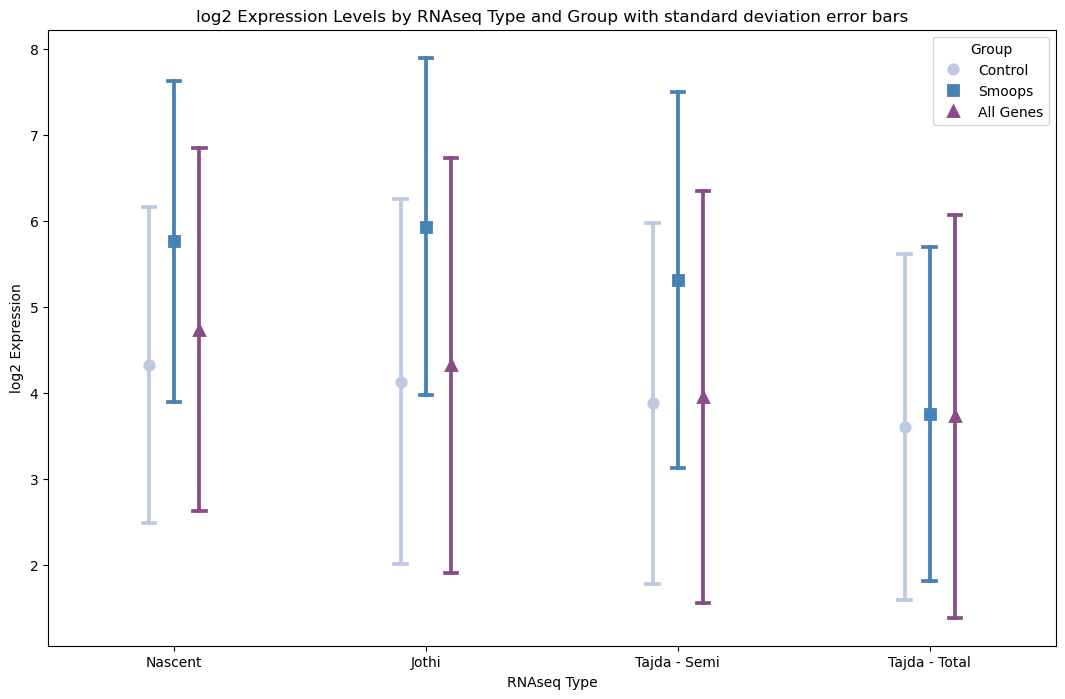

In [12]:
def fetch_expression_data_nascent(subset_genes, expression_data, column_name='gene_id'):
    # Filter expression data for specific genes
    filtered_data = expression_data[expression_data[column_name].isin(subset_genes)]
    filtered_data = filtered_data[['gene_id', '0hrs_Replicate_Average_TPM']].rename(columns={'0hrs_Replicate_Average_TPM': 'expression'})
    return filtered_data

def fetch_expression_data_jothi(subset_genes, expression_data, column_name='gene_id'):
    if column_name != "gene_id":
        subset_genes = set([gene.split('.')[0] for gene in subset_genes])
    # Filter expression data for specific genes
    filtered_data = expression_data[expression_data[column_name].isin(subset_genes)]
    filtered_data = filtered_data[['Unnamed: 0', '0hrs_Replicate_Average_TPM']].rename(columns={'Unnamed: 0': 'gene_id', '0hrs_Replicate_Average_TPM': 'expression'})
    return filtered_data

def fetch_expression_data_our(subset_genes, expression_data, column_name='gene_id', dataset='semi_naive'):
    # Filter expression data for specific genes
    filtered_data = expression_data[expression_data[column_name].isin(subset_genes)]
    filtered_data = filtered_data[['gene_id', f'{dataset}_mean']].rename(columns={f'{dataset}_mean': 'expression'})
    return filtered_data


# Fetch raw expression data
nascent_control_data = fetch_expression_data_nascent(control_common, nascent_rnaseq_gene_id)
nascent_smoops_data = fetch_expression_data_nascent(smoops_naive, nascent_rnaseq_gene_id)
nascent_all_genes_data = fetch_expression_data_nascent(set(semi_naive_deseq["gene_id"]), nascent_rnaseq_gene_id)

jothi_control_data = fetch_expression_data_jothi(control_common, jothi_rnasaq_naive, 'Unnamed: 0')
jothi_smoops_data = fetch_expression_data_jothi(smoops_naive, jothi_rnasaq_naive, 'Unnamed: 0')
jothi_all_genes_data = fetch_expression_data_jothi(set(semi_naive_deseq["gene_id"]), jothi_rnasaq_naive, 'Unnamed: 0')

semi_control_data = fetch_expression_data_our(control_common, expression_data_mean, dataset='semi_naive')
semi_smoops_data = fetch_expression_data_our(smoops_naive, expression_data_mean, dataset='semi_naive')
semi_all_genes_data = fetch_expression_data_our(set(semi_naive_deseq["gene_id"]), expression_data_mean, dataset='semi_naive')

total_control_data = fetch_expression_data_our(control_common, expression_data_mean, dataset='control_naive')
total_smoops_data = fetch_expression_data_our(smoops_naive, expression_data_mean, dataset='control_naive')
total_all_genes_data = fetch_expression_data_our(set(semi_naive_deseq["gene_id"]), expression_data_mean, dataset='control_naive')

# Combine data into a single DataFrame
combined_data = pd.concat([
    nascent_control_data.assign(RNAseq_Type='Nascent', Group='Control'),
    nascent_smoops_data.assign(RNAseq_Type='Nascent', Group='Smoops'),
    nascent_all_genes_data.assign(RNAseq_Type='Nascent', Group='All Genes'),
    jothi_control_data.assign(RNAseq_Type='Jothi', Group='Control'),
    jothi_smoops_data.assign(RNAseq_Type='Jothi', Group='Smoops'),
    jothi_all_genes_data.assign(RNAseq_Type='Jothi', Group='All Genes'),
    semi_control_data.assign(RNAseq_Type='Tajda - Semi', Group='Control'),
    semi_smoops_data.assign(RNAseq_Type='Tajda - Semi', Group='Smoops'),
    semi_all_genes_data.assign(RNAseq_Type='Tajda - Semi', Group='All Genes'),
    total_control_data.assign(RNAseq_Type='Tajda - Total', Group='Control'),
    total_smoops_data.assign(RNAseq_Type='Tajda - Total', Group='Smoops'),
    total_all_genes_data.assign(RNAseq_Type='Tajda - Total', Group='All Genes'),
])


# Make log2 expression
combined_data['log2 Expression'] = np.log2(combined_data['expression'] + 1)

# Define the palette for the groups with hexadecimal colors
hex_palette = {'Control': '#bdcae2', 'Smoops': '#4682B4', 'All Genes': "#894c89"}  # Initially the same color
white_palette = {'Control': '#FFFFFF', 'Smoops': '#FFFFFF', 'All Genes': "#FFFFFF"}  # Initially the same color

# Plotting
plt.figure(figsize=(8, 10))
sns.boxplot(x='RNAseq_Type', y='log2 Expression', hue='Group', data=combined_data, palette=hex_palette, showfliers=False, gap=0.7, whis=0)
sns.violinplot(x='RNAseq_Type', y='log2 Expression', hue='Group', data=combined_data, palette=white_palette, inner=None, gap=0.2)
# remove the boxplot and violinplot legend
#sns.stripplot(x='RNAseq_Type', y='log2 Expression', hue='Group', data=combined_data, palette=hex_palette, dodge=True, s=1.5)
plt.title('log2 Expression Levels by RNAseq Type and Group')
plt.xlabel('RNAseq Type')
plt.ylabel('log2 Expression')
#plt.legend([])

# Create custom legends
# Create custom legends with rectangles
legend_elements = [
    mpatches.Patch(color='#894c89', label='All genes'),
    mpatches.Patch(color='#bdcae2', label='Control'),
    mpatches.Patch(color='#4682B4', label='smOOPS')
]

plt.legend(handles=legend_elements, loc='best')
plt.show()

# Define the palette for the groups with hexadecimal colors
hex_palette = {'Control': '#bdcae2', 'Smoops': '#4682B4', 'All Genes': "#894c89"}  # Colors for the pointplot

smoops_values = {"naive": "#4682B4", "epi": "#008080", 'diff': "#894c89"}
control_values = {"naive": "#bdcae2", "epi": "#b1c7c9", 'diff': "#cdb7d1"}

# show the palette
sns.palplot(smoops_values.values())
sns.palplot(control_values.values())

# Plotting
plt.figure(figsize=(13, 8))
sns.pointplot(x='RNAseq_Type', y='log2 Expression', hue='Group', data=combined_data, palette=hex_palette, markers=['o', 's', '^'], dodge=0.2, join=False, capsize=0.05, errorbar="sd")

plt.title('log2 Expression Levels by RNAseq Type and Group with standard deviation error bars')
plt.xlabel('RNAseq Type')
plt.ylabel('log2 Expression')
plt.legend(title='Group')
plt.show()

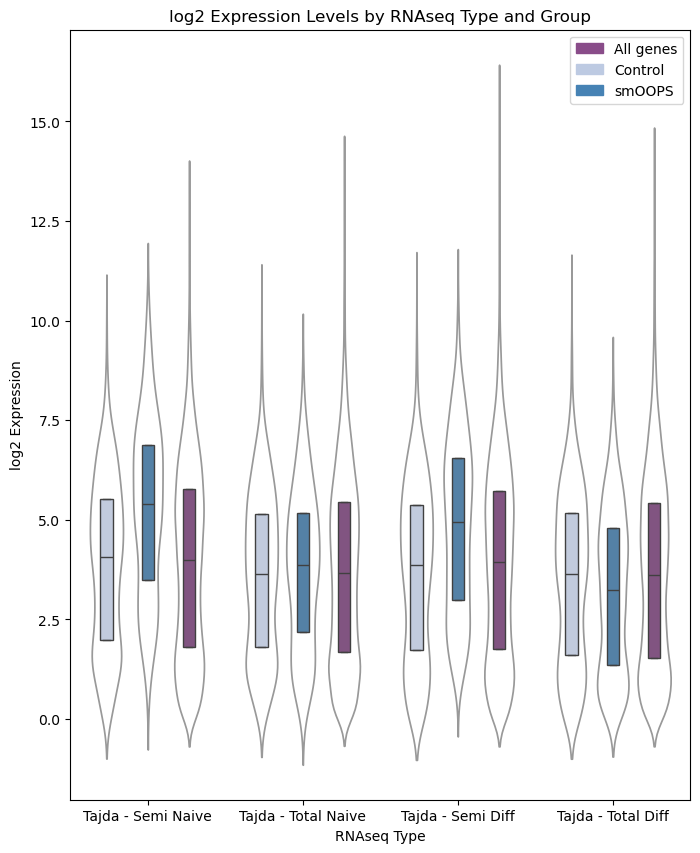

/tmp/ipykernel_3118378/3845099043.py:83: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='RNAseq_Type', y='log2 Expression', hue='Group', data=combined_data, palette=hex_palette, markers=['o', 's', '^'], dodge=0.2, join=False, capsize=0.05, errorbar="sd")


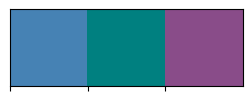

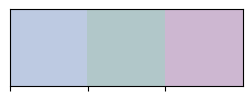

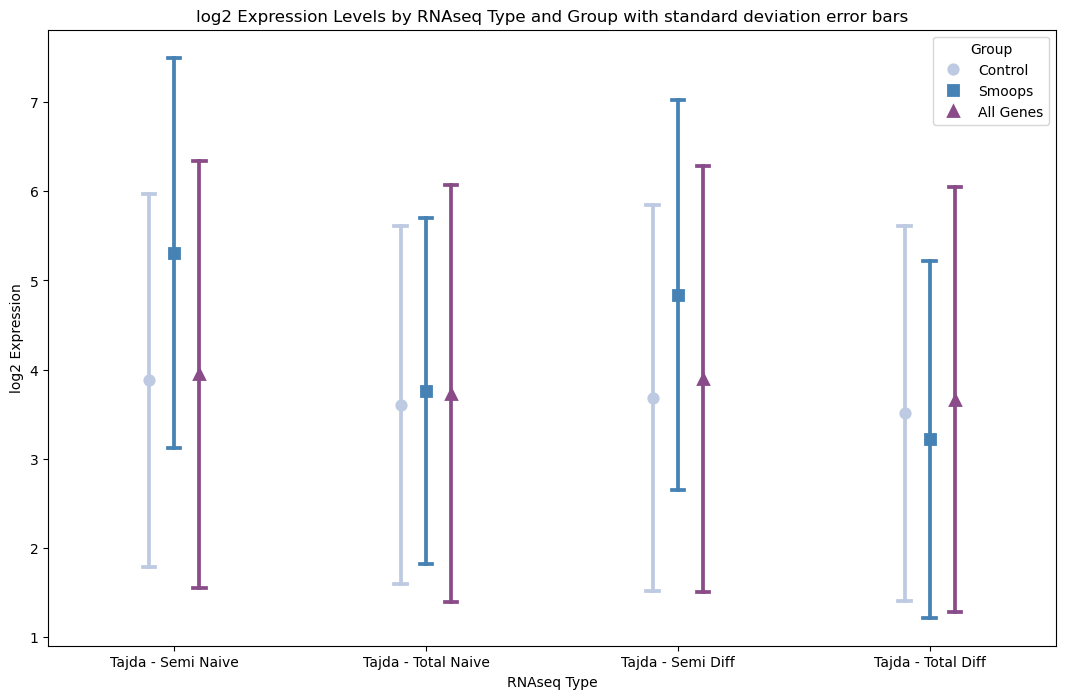

In [13]:
def fetch_expression_data_our(subset_genes, expression_data, dataset='_'):
    # Filter expression data for specific genes
    filtered_data = expression_data[expression_data['gene_id'].isin(subset_genes)]
    filtered_data = filtered_data[['gene_id', f'{dataset}_mean']].rename(columns={f'{dataset}_mean': 'expression'})
    return filtered_data


# Fetch raw expression data
semi_control_data_naive = fetch_expression_data_our(control_common, expression_data_mean, dataset='semi_naive')
semi_smoops_data_naive = fetch_expression_data_our(smoops_naive, expression_data_mean, dataset='semi_naive')
semi_all_genes_data_naive = fetch_expression_data_our(set(semi_naive_deseq["gene_id"]), expression_data_mean, dataset='semi_naive')

total_control_data_naive = fetch_expression_data_our(control_common, expression_data_mean, dataset='control_naive')
total_smoops_data_naive = fetch_expression_data_our(smoops_naive, expression_data_mean, dataset='control_naive')
total_all_genes_data_naive = fetch_expression_data_our(set(semi_naive_deseq["gene_id"]), expression_data_mean, dataset='control_naive')

semi_control_data_diff = fetch_expression_data_our(control_common, expression_data_mean, dataset='semi_diff')
semi_smoops_data_diff = fetch_expression_data_our(smoops_diff, expression_data_mean, dataset='semi_diff')
semi_all_genes_data_diff = fetch_expression_data_our(set(semi_naive_deseq["gene_id"]), expression_data_mean, dataset='semi_diff')

total_control_data_diff = fetch_expression_data_our(control_common, expression_data_mean, dataset='control_diff')
total_smoops_data_diff = fetch_expression_data_our(smoops_diff, expression_data_mean, dataset='control_diff')
total_all_genes_data_diff = fetch_expression_data_our(set(semi_naive_deseq["gene_id"]), expression_data_mean, dataset='control_diff')

# Combine data into a single DataFrame
combined_data = pd.concat([
    semi_control_data_naive.assign(RNAseq_Type='Tajda - Semi Naive', Group='Control'),
    semi_smoops_data_naive.assign(RNAseq_Type='Tajda - Semi Naive', Group='Smoops'),
    semi_all_genes_data_naive.assign(RNAseq_Type='Tajda - Semi Naive', Group='All Genes'),
    total_control_data_naive.assign(RNAseq_Type='Tajda - Total Naive', Group='Control'),
    total_smoops_data_naive.assign(RNAseq_Type='Tajda - Total Naive', Group='Smoops'),
    total_all_genes_data_naive.assign(RNAseq_Type='Tajda - Total Naive', Group='All Genes'),
    
    semi_control_data_diff.assign(RNAseq_Type='Tajda - Semi Diff', Group='Control'),
    semi_smoops_data_diff.assign(RNAseq_Type='Tajda - Semi Diff', Group='Smoops'),
    semi_all_genes_data_diff.assign(RNAseq_Type='Tajda - Semi Diff', Group='All Genes'),
    total_control_data_diff.assign(RNAseq_Type='Tajda - Total Diff', Group='Control'),
    total_smoops_data_diff.assign(RNAseq_Type='Tajda - Total Diff', Group='Smoops'),
    total_all_genes_data_diff.assign(RNAseq_Type='Tajda - Total Diff', Group='All Genes'),    
])


# Make log2 expression
combined_data['log2 Expression'] = np.log2(combined_data['expression'] + 1)

# Define the palette for the groups with hexadecimal colors
hex_palette = {'Control': '#bdcae2', 'Smoops': '#4682B4', 'All Genes': "#894c89"}  # Initially the same color
white_palette = {'Control': '#FFFFFF', 'Smoops': '#FFFFFF', 'All Genes': "#FFFFFF"}  # Initially the same color

# Plotting
plt.figure(figsize=(8, 10))
sns.boxplot(x='RNAseq_Type', y='log2 Expression', hue='Group', data=combined_data, palette=hex_palette, showfliers=False, gap=0.7, whis=0)
sns.violinplot(x='RNAseq_Type', y='log2 Expression', hue='Group', data=combined_data, palette=white_palette, inner=None, gap=0.2)

# remove the boxplot and violinplot legend
#sns.stripplot(x='RNAseq_Type', y='log2 Expression', hue='Group', data=combined_data, palette=hex_palette, dodge=True, s=1.5)
plt.title('log2 Expression Levels by RNAseq Type and Group')
plt.xlabel('RNAseq Type')
plt.ylabel('log2 Expression')

# Create custom legends with rectangles
legend_elements = [
    mpatches.Patch(color='#894c89', label='All genes'),
    mpatches.Patch(color='#bdcae2', label='Control'),
    mpatches.Patch(color='#4682B4', label='smOOPS')
]

plt.legend(handles=legend_elements, loc='best')
plt.show()

# Define the palette for the groups with hexadecimal colors
hex_palette = {'Control': '#bdcae2', 'Smoops': '#4682B4', 'All Genes': "#894c89"}  # Colors for the pointplot

smoops_values = {"naive": "#4682B4", "epi": "#008080", 'diff': "#894c89"}
control_values = {"naive": "#bdcae2", "epi": "#b1c7c9", 'diff': "#cdb7d1"}

# show the palette
sns.palplot(smoops_values.values())
sns.palplot(control_values.values())

# Plotting
plt.figure(figsize=(13, 8))
sns.pointplot(x='RNAseq_Type', y='log2 Expression', hue='Group', data=combined_data, palette=hex_palette, markers=['o', 's', '^'], dodge=0.2, join=False, capsize=0.05, errorbar="sd")

plt.title('log2 Expression Levels by RNAseq Type and Group with standard deviation error bars')
plt.xlabel('RNAseq Type')
plt.ylabel('log2 Expression')
plt.legend(title='Group')
plt.show()